### Mnist分类任务：

- 网络基本构建与训练方法，常用函数解析

- torch.nn.functional模块

- nn.Module模块


### 读取Mnist数据集
- 会自动进行下载

In [1]:
%matplotlib inline

In [2]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [3]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

In [4]:
y_train[0]

5

784是mnist数据集每个样本的像素点个数

(50000, 784)


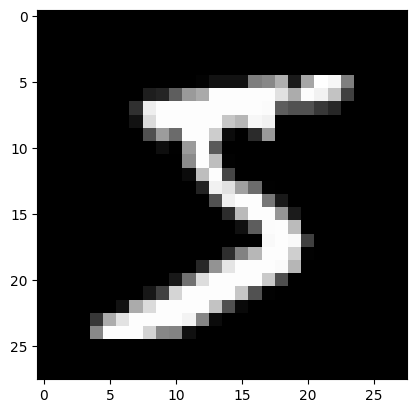

In [5]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

<img src="./img/4.png" alt="FAO" width="790">

<img src="./img/5.png" alt="FAO" width="790">

注意数据需转换成tensor才能参与后续建模训练


In [6]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


### torch.nn.functional 很多层和函数在这里都会见到

torch.nn.functional中有很多功能，后续会常用的。那什么时候使用nn.Module，什么时候使用nn.functional呢？一般情况下，如果模型有可学习的参数，最好用nn.Module，其他情况nn.functional相对更简单一些

In [7]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb.mm(weights) + bias

In [8]:
bs = 64
xb = x_train[0:bs]  # a mini-batch from x
yb = y_train[0:bs]
weights = torch.randn([784, 10], dtype = torch.float,  requires_grad = True) 
bs = 64
bias = torch.zeros(10, requires_grad=True)

print(loss_func(model(xb), yb))

tensor(12.8754, grad_fn=<NllLossBackward0>)


### 创建一个model来更简化代码

- 必须继承nn.Module且在其构造函数中需调用nn.Module的构造函数
- 无需写反向传播函数，nn.Module能够利用autograd自动实现反向传播
- Module中的可学习参数可以通过named_parameters()或者parameters()返回迭代器

In [9]:
from torch import nn

class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(784, 128)
        self.hidden2 = nn.Linear(128, 256)
        self.out  = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.out(x)
        return x
        

In [10]:
net = Mnist_NN()
print(net)


Mnist_NN(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
)


可以打印我们定义好名字里的权重和偏置项

In [11]:
for name, parameter in net.named_parameters():
    print(name, parameter,parameter.size())

hidden1.weight Parameter containing:
tensor([[-0.0111,  0.0216,  0.0137,  ...,  0.0156,  0.0082,  0.0270],
        [ 0.0340,  0.0354,  0.0072,  ..., -0.0189, -0.0209,  0.0254],
        [-0.0341, -0.0029, -0.0167,  ..., -0.0234, -0.0184, -0.0106],
        ...,
        [-0.0146, -0.0317, -0.0072,  ...,  0.0040,  0.0229, -0.0164],
        [ 0.0353,  0.0100, -0.0065,  ..., -0.0310, -0.0099,  0.0181],
        [-0.0040, -0.0330, -0.0260,  ..., -0.0193,  0.0328,  0.0348]],
       requires_grad=True) torch.Size([128, 784])
hidden1.bias Parameter containing:
tensor([ 0.0073,  0.0227, -0.0351,  0.0307,  0.0120, -0.0247,  0.0053, -0.0010,
         0.0048,  0.0269, -0.0245,  0.0012,  0.0011, -0.0103,  0.0353,  0.0263,
         0.0265, -0.0113,  0.0270, -0.0258,  0.0180, -0.0249, -0.0172, -0.0339,
        -0.0211, -0.0005, -0.0040,  0.0277, -0.0015,  0.0152,  0.0268, -0.0176,
        -0.0250,  0.0291,  0.0060,  0.0089, -0.0245,  0.0339, -0.0212, -0.0083,
         0.0319, -0.0317, -0.0215, -0.0120, 

### 使用TensorDataset和DataLoader来简化

In [12]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [13]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

- 一般在训练模型时加上model.train()，这样会正常使用Batch Normalization和 Dropout
- 测试的时候一般选择model.eval()，这样就不会使用Batch Normalization和 Dropout

In [14]:
import numpy as np

def fit(steps, model, loss_func, opt, train_dl, valid_dl):
    for step in range(steps):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        print('当前step:'+str(step), '验证集损失：'+str(val_loss))

In [15]:
from torch import optim
def get_model():
    model = Mnist_NN()
    return model, optim.SGD(model.parameters(), lr=0.001)

In [16]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

### 三行搞定！

In [17]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(20, model, loss_func, opt, train_dl, valid_dl)

当前step:0 验证集损失：2.277573703765869
当前step:1 验证集损失：2.246312379837036
当前step:2 验证集损失：2.1982615325927735
当前step:3 验证集损失：2.1192152908325195
当前step:4 验证集损失：1.988429735183716
当前step:5 验证集损失：1.7876382356643676
当前step:6 验证集损失：1.5302555858612061
当前step:7 验证集损失：1.267729371070862
当前step:8 验证集损失：1.0481321079254151
当前step:9 验证集损失：0.8854651832580567
当前step:10 验证集损失：0.769311152267456
当前step:11 验证集损失：0.6852361001968383
当前step:12 验证集损失：0.6232443956375122
当前step:13 验证集损失：0.5756664014816284
当前step:14 验证集损失：0.5385847574710846
当前step:15 验证集损失：0.5087478234291076
当前step:16 验证集损失：0.4844760150909424
当前step:17 验证集损失：0.4640840609550476
当前step:18 验证集损失：0.44730802721977236
当前step:19 验证集损失：0.4327502868175507


In [18]:
correct = 0
total = 0
for xb, yb in valid_dl:
    outputs = model(xb)
    _, predicted = torch.max(outputs.data, 1)
    total += yb.size(0)
    correct += (predicted == yb).sum().item()
print("Accurancy of the network on the 1000 test images: %d %%" % (100 * correct / total))

Accurancy of the network on the 1000 test images: 88 %
